In [35]:
%matplotlib inline

from dowhy.do_samplers.kernel_density_sampler import KernelDensitySampler
from dowhy.do_why import CausalModel

import numpy as np
import pandas as pd

In [36]:
import dowhy.datasets

data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)

In [37]:
data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'
data['df']

,X0,v,y
0,-0.611072,0.0,-2.528997
1,1.635530,1.0,16.768841
2,2.675698,1.0,21.073701
3,-1.308102,0.0,-5.413741
4,1.450060,1.0,16.001251
5,0.165331,1.0,10.684241
6,2.216487,1.0,19.173202
7,2.570246,1.0,20.637278
8,-1.430385,0.0,-5.919824
9,0.736826,1.0,13.049445


In [38]:
data['dot_graph']

'digraph { v ->y;X0-> v;X0-> y;}'

In [51]:
causal_model= CausalModel(
                            data=data["df"],
                            treatment=data["treatment_name"],
                            outcome=data["outcome_name"],
                            graph=data["dot_graph"])

Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
['X0']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment v on outcome y


In [52]:
identified_estimand = causal_model.identify_effect()

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X0', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] yes


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [54]:
import pymc3 as pm
import networkx as nx

In [44]:
with pm.Model() as model:
    x0 = pm.Normal('X0', mu=data['df'].mean()['X0'], sd=data['df'].std()['X0'], observed=data['df']['X0'])
    
    beta_xv = pm.Normal('beta_xv', mu=0, sd=50)
    beta_v = pm.Normal('beta_v', mu=0, sd=50)
    v = pm.Bernoulli('v', p=1. / (1. + np.exp(-(beta_xv * x0 + beta_v))), observed=data['df']['v'])
    
    beta_vy = pm.Normal('beta_vy', mu=0, sd=50)
    beta_xy = pm.Normal('beta_xy', mu=0, sd=50)
    beta_y = pm.Normal('beta_y', mu=0, sd=50)

    y = pm.Normal('y', mu=beta_vy * v + beta_xy * x0 + beta_y, sd=data['df'].std()['y'], observed=data['df']['y'])
    trace = pm.sample(len(data['df']), cores=12)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (12 chains in 12 jobs)
INFO:pymc3:NUTS: [beta_y, beta_xy, beta_vy, beta_v, beta_xv]
Sampling 12 chains: 100%|██████████| 18000/18000 [00:09<00:00, 1974.35draws/s]


In [57]:
g = causal_model._graph.get_unconfounded_observed_subgraph()

if nx.is_directed_acyclic_graph(g):
    with pm.Model() as model:
        for node in nx.topological_sort(g):
            if len(g.in_edges(node)) == 0:
                pass
            else:
                g.nodes[node]["pymc_parameters"] = [pm.Normal("beta_{}".format(node), mu=0, sd=50)]
                for parent, child in g.in_edges(node):
                    g.nodes[node]["parameters"].append(pm.Normal("beta_{}_{}".format(parent, child), mu=0, sd=50))
                g.nodes[node]["pymc_variable"] = pm.Normal(node, mu=, sd=)
            
else:
    raise Exception("Graph is not a DAG!")

X0
v
y


In [64]:
g.in_edges('y')

InMultiEdgeDataView([('v', 'y'), ('X0', 'y')])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3c2f16cf60>,
      dtype=object)

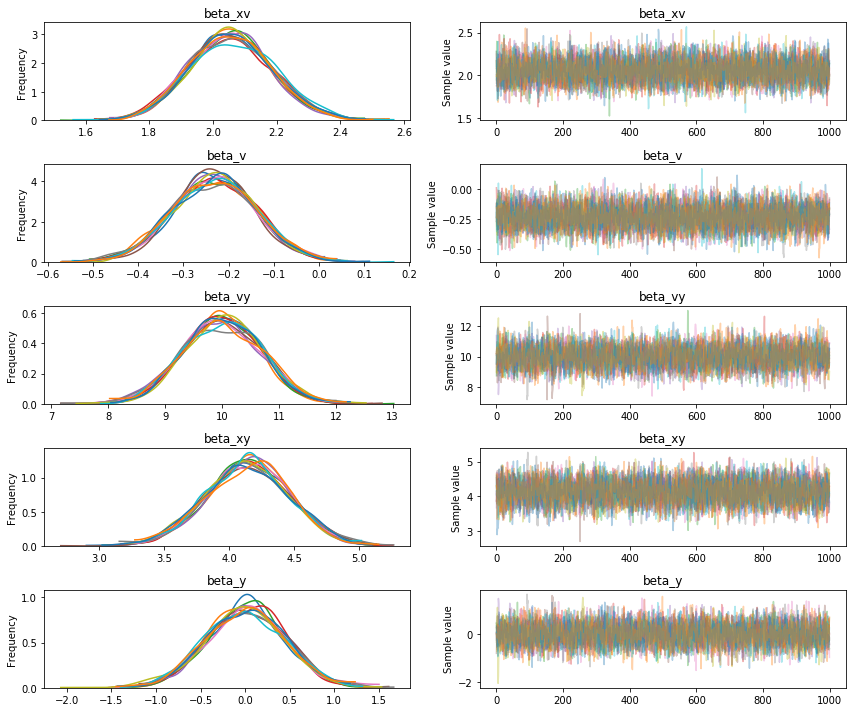

In [45]:
pm.traceplot(trace)

In [46]:
with pm.Model() as model:
    x0 = pm.Normal('X0', mu=data['df'].mean()['X0'], sd=data['df'].std()['X0'], observed=data['df']['X0'])
    
    #beta_xv = pm.Normal('beta_xv', mu=trace['beta_xv'].mean(axis=0), sd=trace['beta_xv'].std(axis=0))
    #beta_v = pm.Normal('beta_v', mu=trace['beta_v'].mean(axis=0), sd=trace['beta_v'].std(axis=0))
    #v = pm.Bernoulli('v', logit_p=1. / (1. + np.exp(-beta_v)))
    v = 1.
    
    beta_vy = pm.Normal('beta_vy', mu=trace['beta_vy'].mean(axis=0), sd=trace['beta_vy'].std(axis=0))
    beta_xy = pm.Normal('beta_xy', mu=trace['beta_xy'].mean(axis=0), sd=trace['beta_xy'].std(axis=0))

    y = pm.Normal('y', mu=beta_vy * v + beta_xy * x0, sd=data['df'].std()['y'], shape=(len(data['df']),))
    trace_1 = pm.sampling.sample_prior_predictive(len(data['df']))

In [47]:
trace_1['y'].mean()

In [48]:
with pm.Model() as model:
    x0 = pm.Normal('X0', mu=data['df'].mean()['X0'], sd=data['df'].std()['X0'], observed=data['df']['X0'])
    
    #beta_xv = pm.Normal('beta_xv', mu=trace['beta_xv'].mean(axis=0), sd=trace['beta_xv'].std(axis=0))
    #beta_v = pm.Normal('beta_v', mu=trace['beta_v'].mean(axis=0), sd=trace['beta_v'].std(axis=0))
    #v = pm.Bernoulli('v', logit_p=1. / (1. + np.exp(-beta_v)))
    v = 0.
    
    beta_vy = pm.Normal('beta_vy', mu=trace['beta_vy'].mean(axis=0), sd=trace['beta_vy'].std(axis=0))
    beta_xy = pm.Normal('beta_xy', mu=trace['beta_xy'].mean(axis=0), sd=trace['beta_xy'].std(axis=0))

    y = pm.Normal('y', mu=beta_vy * v + beta_xy * x0, sd=data['df'].std()['y'], shape=(len(data['df']),))
    trace_0 = pm.sampling.sample_prior_predictive(len(data['df']))

In [49]:
trace_0['y'].mean()

In [50]:
trace_1['y'].mean() - trace_0['y'].mean()